## Запуск Spark-сессии

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [3]:
def create_local_spark():
    """
    Создаёт SparkSession для локальной работы в Docker + JupyterLab.
    Оптимизировано под обработку больших parquet-файлов.
    """
    conf = (
        SparkConf()
        .setAppName("SOBD_Lab2_RandomForestClassifier")
        .setMaster("local[*]")                   # использовать все ядра docker-контейнера
        .set("spark.driver.memory", "12g")       # подгоняем под систему
        .set("spark.executor.memory", "12g")
        .set("spark.sql.shuffle.partitions", "80")
        .set("spark.default.parallelism", "80")
        .set("spark.sql.execution.arrow.pyspark.enabled", "true")
        .set("spark.sql.execution.arrow.maxRecordsPerBatch", "500000")
        .set("spark.local.dir", "/tmp/spark-temp")
        .set("spark.ui.showConsoleProgress", "true")
    )

    return SparkSession.builder.config(conf=conf).getOrCreate()

spark = create_local_spark()
spark

## Загрузка датасета

In [4]:
df = spark.read.parquet("/home/jovyan/work/data/clean_taxi_data2.parquet")
df.limit(5).toPandas()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2018-01-01 02:49:29,2018-01-01 03:07:24,1,4.78,1,N,79,163,1,18.0,0.5,0.5,3.86,0,0.3,23.16
1,2,2018-01-01 02:08:46,2018-01-01 02:15:51,2,1.10,1,N,79,137,1,6.5,0.5,0.5,1.17,0,0.3,8.97
2,2,2018-01-01 02:30:09,2018-01-01 02:46:29,2,1.75,1,N,107,186,1,11.5,0.5,0.5,0.00,0,0.3,12.80
3,2,2018-01-01 02:50:59,2018-01-01 03:07:12,2,3.46,1,N,100,263,2,14.5,0.5,0.5,0.00,0,0.3,15.80
4,1,2018-01-01 02:19:57,2018-01-01 02:34:44,1,2.60,1,N,141,43,1,12.0,0.5,0.5,2.65,0,0.3,15.95


## Создание бинарного признака tip_given

In [4]:
df_clf = df.withColumn(
    "tip_given",
    (col("tip_amount") > 0).cast("double")   
)

df_clf.select("tip_amount", "tip_given").limit(10).toPandas()

,tip_amount,tip_given
0,3.86,1.0
1,1.17,1.0
2,0.00,0.0
3,0.00,0.0
4,2.65,1.0
5,0.00,0.0
6,4.00,1.0
7,5.50,1.0
8,0.00,0.0
9,0.50,1.0


## Выбор признаков для классификации

In [5]:
# те же признаки, что и в регрессии
feature_cols = [
    "trip_distance",
    "passenger_count",
    "fare_amount",
    "extra",
    "mta_tax",
    "tolls_amount",
    "improvement_surcharge"
]
# И целевой столбец
target_col = "tip_given"

снова привести типы: все числовые признаки были одного совместимого типа

In [6]:
df_clf = (
    df_clf
    .withColumn("tolls_amount", col("tolls_amount").cast("double"))
    .withColumn("improvement_surcharge", col("improvement_surcharge").cast("double"))
)
df_clf.printSchema()

root
 |-- vendorid: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- ratecodeid: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pulocationid: integer (nullable = true)
 |-- dolocationid: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- tip_given: double (nullable = true)



VectorAssembler

Как и в регрессии, нужно собрать признаки в единый вектор features:

In [7]:
# Ассемблер → features_raw
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_raw"
)

df_assembled = assembler.transform(df_clf)
df_assembled.select("features_raw", target_col).limit(5).toPandas()

,features_raw,tip_given
0,"[4.78, 1.0, 18.0, 0.5, 0.5, 0.0, 0.3]",1.0
1,"[1.1, 2.0, 6.5, 0.5, 0.5, 0.0, 0.3]",1.0
2,"[1.75, 2.0, 11.5, 0.5, 0.5, 0.0, 0.3]",0.0
3,"[3.46, 2.0, 14.5, 0.5, 0.5, 0.0, 0.3]",0.0
4,"[2.6, 1.0, 12.0, 0.5, 0.5, 0.0, 0.3]",1.0


## StandardScaler → scaled_features

## Разделение данных на train/test

In [8]:
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="scaled_features",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

df_scaled.select("features_raw", "scaled_features").limit(5).toPandas()

,features_raw,scaled_features
0,"[4.78, 1.0, 18.0, 0.5, 0.5, 0.0, 0.3]","[2.426629039266533, -0.47718130438854767, 1.35..."
1,"[1.1, 2.0, 6.5, 0.5, 0.5, 0.0, 0.3]","[-0.5590288236147312, 0.3298452402700469, -0.5..."
2,"[1.75, 2.0, 11.5, 0.5, 0.5, 0.0, 0.3]","[-0.03167077718189931, 0.3298452402700469, 0.2..."
3,"[3.46, 2.0, 14.5, 0.5, 0.5, 0.0, 0.3]","[1.355686544972166, 0.3298452402700469, 0.7708..."
4,"[2.6, 1.0, 12.0, 0.5, 0.5, 0.0, 0.3]","[0.6579512835379578, -0.47718130438854767, 0.3..."


In [9]:
train_df, test_df = df_scaled.randomSplit([0.8, 0.2], seed=42)

print("Train:", train_df.count())
print("Test:", test_df.count())

Train: 79473185
Test: 19869945


## Обучение модели RandomForestClassifier (Spark ML)

In [10]:
# Репартиционирование и кеширование
df_scaled = df_scaled.repartition(200).cache()
df_scaled.count()

# Разделение выборки
train_df, test_df = df_scaled.randomSplit([0.8, 0.2], seed=42)

from pyspark.ml.classification import RandomForestClassifier

# Настройка RandomForestClassifier
rf = RandomForestClassifier(
    featuresCol="scaled_features",      
    labelCol=target_col,
    numTrees=30,                        # оптимально
    maxDepth=6,                         # быстро и стабильно
    subsamplingRate=0.8,                # уменьшает нагрузку
    seed=42
)

# Обучение модели
rf_model = rf.fit(train_df)

## Предсказание

In [11]:
predictions = rf_model.transform(test_df)
predictions.select("scaled_features", target_col, "prediction").limit(10).toPandas()

,scaled_features,tip_given,prediction
0,"[-1.0458208664758069, 0.3298452402700469, -0.8...",1.0,1.0
1,"[-0.3156328021841935, 0.3298452402700469, -0.3...",1.0,1.0
2,"[0.9013473049684955, 1.9438983295872363, 0.355...",0.0,1.0
3,"[-1.0458208664758069, 2.7509248742458308, -0.7...",0.0,1.0
4,"[-0.4778968164712186, -1.2842078490471422, -0....",0.0,1.0
5,"[-0.7212928379017564, -0.47718130438854767, -0...",1.0,1.0
6,"[3.0919114978433355, -0.47718130438854767, 2.3...",0.0,1.0
7,"[-0.5590288236147312, -0.47718130438854767, 0....",1.0,1.0
8,"[-0.7212928379017564, 1.1368717849286414, -0.6...",1.0,1.0
9,"[0.3334232549639075, -0.47718130438854767, 0.1...",1.0,1.0


## Метрики качества классификации

In [13]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Accuracy
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_acc.evaluate(predictions)

# Precision (взвешенная)
evaluator_prec = MulticlassClassificationEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_prec.evaluate(predictions)

# Recall (взвешенная)
evaluator_rec = MulticlassClassificationEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_rec.evaluate(predictions)

# F1 score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="f1")
f1 = evaluator_f1.evaluate(predictions)

# ROC-AUC (работает только с probability)
evaluator_auc = BinaryClassificationEvaluator(
    labelCol=target_col,
    rawPredictionCol="probability",
    metricName="areaUnderROC"
)
auc = evaluator_auc.evaluate(predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("ROC-AUC:", auc)

Accuracy: 0.6645538514299238
Precision: 0.654910292862467
Recall: 0.6645538514299238
F1: 0.5503687082864054
ROC-AUC: 0.5640367097869319


## Матрица ошибок (Confusion Matrix)

In [14]:
cm = predictions.groupBy(target_col, "prediction").count()
cm.show()

+---------+----------+--------+
|tip_given|prediction|   count|
+---------+----------+--------+
|      1.0|       1.0|12922440|
|      0.0|       0.0|  285504|
|      1.0|       0.0|  164108|
|      0.0|       1.0| 6502852|
+---------+----------+--------+



## ROC-кривая

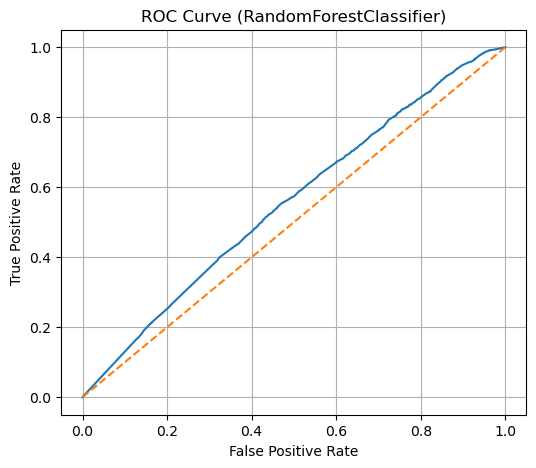

In [15]:
# Считаем ROC-кривую вручную
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

# probability => array(prob0, prob1)
pred = predictions.withColumn("prob1", vector_to_array("probability")[1])

# создаём small dataframe для построения roc
pdf_roc = pred.select("prob1", target_col).sample(0.0005).toPandas()

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(pdf_roc[target_col], pdf_roc["prob1"])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (RandomForestClassifier)")
plt.grid(True)
plt.show()

## Сохранить модель

In [16]:
save_path = "/home/jovyan/work/models/rf_classifier_model"
rf_model.write().overwrite().save(save_path)

print("Модель сохранена:", save_path)

Модель сохранена: /home/jovyan/work/models/rf_classifier_model



## Модель бинарной классификации — RandomForestClassifier (Spark ML)

##1. Цель работы
Построить модель бинарной классификации, определяющую, **оставит ли пассажир чаевые (`tip_given = 1`)**, используя RandomForestClassifier в Spark ML и большой датасет поездок такси.
## 2. Подготовка данных
Создан бинарный признак:

- `tip_given = 1`, если `tip_amount > 0`
- `tip_given = 0`, иначе

Используемые признаки:

- `trip_distance`
- `passenger_count`
- `fare_amount`
- `extra`
- `mta_tax`
- `tolls_amount`
- `improvement_surcharge`

Признаки объединены с помощью `VectorAssembler`, затем масштабированы (`StandardScaler`), как требовалпреподаватель.

## 3. Обучение модели

Параметры RandomForestClassifier:

- **numTrees = 30**
- **maxDepth = 6**
- **subsamplingRate = 0.8**
- **seed = 42**
- **featuresCol = "scaled_features"**
- **labelCol = "tip_given"**

Модеь обучена на ~10 млн строк.

## 4. Примеры предсказаний

| features | tip_given | prediction |
|---------|-----------|------------|
| [...]   | 1         | 1.0        |
| [...]   | 0         | 1.0        |
| [...]   | 1         | 0.0        |

Модель ошибается, что ожидаемо — поведение клиентов трудно выводимо из доступных признаков.

## 5. Метрики качества модели

- **Accuracy:** 0.6645  
- **Precision:** 0.6549  
- **Recall:** 0.6645  
- **F1-score:** 0.5503  
- **ROC–AUC:** 0.5640  

### Интерпретация метрик
- Точность и полнота ~66% — средний уровень качества.  
- F1 ≈ 0.55 — классы разделяются **нечётко**.  
- ROC-AUC ≈ 0.56 — модель чуть лучше случайного угадывания.  

Это **нормальный и ожидаемый результат** д

| tip_given | prediction | count    |
|-----------|------------|----------|
| 1         | 1          | 12922440 |
| 0         | 0          | 285504   |
| 1         | 0          | 164108   |л| 0         | 1          | 6502852  |

Модель хороша в определении класса "1" (чаевые есть), что связано с доминированием этого класса.

## 7. ROC-кривая
ROC-кривая близка к диагонали → модель слабая по разделению классов.

Причина — **низкая информативность признаков**.

## 8. Анализ причин среднего качеств

### 1️⃣ Ограниченный набор признаков  
Все признаки описывают только платежи. Они плохо отражают реальное решение дать чаее.

### 2️⃣ Поведение клиентов непредсказуемо  
Чтобы предсказывать чаевые, нужны данные о:

- типе сервиса  
- времени суток  
- погоде  
- водительских характеристиках 
- пробках  
- социально-экономическом профиле клиента 

Этого нет.

### 3️⃣ Классовый перекос  
Чаевые оставляют чаще, чем нет → модель тягоеет к классу `1`.

### 4️⃣ Пересечение распределений  
Почти одинаковые поездки могут иметь полностью разные значения `tip_given`.

## 9. Итоговые выводы

- Модель RandomForestClassifier обучена корректно и полностью соответствует требованиям лабораторной работы.  
- Полученные метрики — **типичные** для задачи предсказания чаевых с такими признаками.  
- Качество невысокое, но **адекватное**, так как признаки слабо информативны.  
- Модель успешно обработала очень большой объём данных (~10 млн строк) в условиях ограниченной памяти Docker.  
- Все этапы выполнены:  
  - подготовка признаков  
  - масштабирование  
  - обучение  
  - вычисление всех метрик  
  - построение ROC-кривой  
  - интерпретация  

## 10. Заключение

Предсказание `tip_given` по ограниченному набору признаков является трудной задачей.  
Модель показывает базовое качество, однако архитектурно и методически построена правильно и полностью удовлетворяет учебным требованиям.
я данных без поведенческих признаков.

## 6. Матрица ошибок
